## Accessing NOAA's Sea Surface Temperature - Optimum Interpolation CDR Climate Data Record (CDR) with the Planetary Computer STAC API

The NOAA 1/4° daily Optimum Interpolation Sea Surface Temperature (or daily OISST) Climate Data Record (CDR) provides complete ocean temperature fields constructed by combining bias-adjusted observations from different platforms (satellites, ships, buoys) on a regular global grid, with gaps filled in by interpolation. The main input source is satellite data from the Advanced Very High Resolution Radiometer (AVHRR), which provides high temporal-spatial coverage from late 1981-present. This input must be adjusted to the buoys due to erroneous cold SST data following the Mt Pinatubo and El Chichon eruptions. Applications include climate modeling, resource management, ecological studies on annual to daily scales.

### Data access

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) sets the environment variable "PC_SDK_SUBSCRIPTION_KEY" when your server is started. When your Planetary Computer [account request](https://planetarycomputer.microsoft.com/account/request) was approved, a pair of subscription keys were automatically generated for you. You can view your keys by singing in to the [developer portal](https://planetarycomputer.developer.azure-api.net/). The API key may be set manually via the following code:

```python
pc.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more. 

First, let's fetch all items from the one day in 1981.

In [15]:
import planetary_computer
import pystac_client

client = pystac_client.Client.open(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac",
    modifier=planetary_computer.sign_inplace,
)
item_search = client.search(
    collections="noaa-cdr-sea-surface-temperature-whoi",
    datetime="1988-01-01T22:00:00Z",
)
item = next(item_search.items())
print(item)

<Item id=SEAFLUX-OSB-CDR_V02R00_SST_D19880101_C20160820-7>


### Assets

Each item has a Cloud Optimized GeoTIFF (COG) asset containing the sea surface temperature.

In [16]:
from rich.table import Table

table = Table("Key", "Title")
for key, asset in item.assets.items():
    table.add_row(key, asset.title)
table

┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                     ┃ Title                               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ fill_missing_qc         │ Quality flag for missing data       │
│ sea_surface_temperature │ NOAA CDR of sea surface temperature │
│ tilejson                │ TileJSON with default rendering     │
│ rendered_preview        │ Rendered preview                    │
└─────────────────────────┴─────────────────────────────────────┘

### Load data

Let's load all the data into an xarray using **odc-stac**, converting our nodata values to `nan` and scaling the data to degrees Celsius.

In [17]:
import odc.stac

data = odc.stac.load([item], bands="sea_surface_temperature")
data

<xarray.Dataset>
Dimensions:                  (latitude: 720, longitude: 1440, time: 1)
Coordinates:
  * latitude                 (latitude) float64 89.88 89.62 ... -89.62 -89.88
  * longitude                (longitude) float64 -179.9 -179.6 ... 179.6 179.9
    spatial_ref              int32 4326
  * time                     (time) datetime64[ns] 1988-01-01T21:00:00
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 nan nan ... nan

### Visualize

Now, let's visualize one day's data.

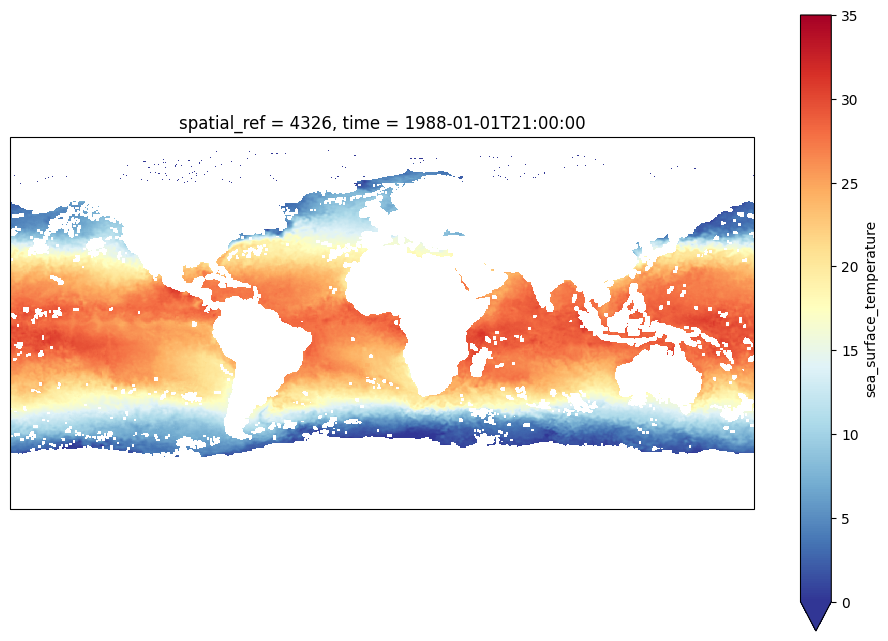

In [18]:
from cartopy import crs
from matplotlib import pyplot

figure = pyplot.figure(figsize=(12, 8))
axes = pyplot.axes(projection=crs.Mercator())
data["sea_surface_temperature"][0].plot.imshow(cmap="RdYlBu_r", vmin=0, vmax=35)

### NetCDF data

We recommend using the Cloud-Optimized GeoTIFF assets provided by the `noaa-cdr-sea-surface-temperature-whoi` collection, but if you'd like to use the source NetCDFs that the COGs were created from, you can as well.
Those are stored in the `noaa-cdr-sea-surface-temperature-whoi-netcdf` collection.

In [19]:
item_search = client.search(
    collections="noaa-cdr-sea-surface-temperature-whoi-netcdf",
    datetime="1988-01-01T22:00:00Z",
)
item = next(item_search.items())
print(item)

<Item id=SEAFLUX-OSB-CDR_V02R00_SST_D19880101_C20160820>


You can use `xarray` (via `fsspec`) to access the data in the NetCDF.

<xarray.Dataset>
Dimensions:                  (time: 8, lat: 720, lon: 1440)
Coordinates:
  * time                     (time) float32 1.5 4.5 7.5 10.5 13.5 16.5 19.5 22.5
  * lat                      (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                      (lon) float32 0.125 0.375 0.625 ... 359.6 359.9
Data variables:
    sea_surface_temperature  (time, lat, lon) float32 ...
    fill_missing_qc          (time, lat, lon) float32 ...
Attributes: (12/39)
    Conventions:                CF-1.6
    title:                      NOAA Climate Data Record of Sea Surface Tempe...
    source:                     SEAFLUX-OSB-CDR_V02R00_ATMOS_D19880101_C20160...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v2.0.2, NOA...
    standard_name_vocabulary:   CF Standard Name Table (v26, 08 November 2013)
    ID:                         SEAFLUX-OSB-CDR_V02R00_SST_D19880101_C2016082...
    ...                         ...
    cdr_variable:               sea_surface_temperature
    metadata_link:              gov.noaa.ncdc:C00972
    product_version:            V02R00
    platform:                   NASA Earth System Science Pathfinder
    sensor:                     AVHRR > Advanced Very High Resolution Radiometer
    spatial_resolution:         0.25 degree x 0.25 degree; equal-angle grid

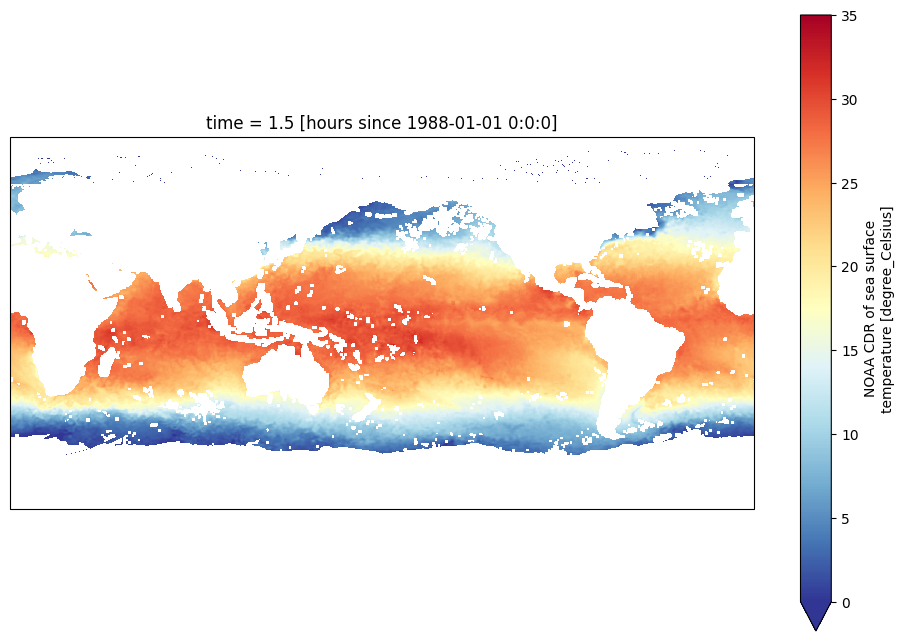

In [20]:
import fsspec
import xarray
from IPython.display import display

figure = pyplot.figure(figsize=(12, 8))
axes = pyplot.axes(projection=crs.Mercator())
with fsspec.open(item.assets["netcdf"].href) as file:
    with xarray.open_dataset(file, decode_times=False) as dataset:
        display(dataset)
        dataset["sea_surface_temperature"].isel(time=0).squeeze().plot.imshow(
            cmap="RdYlBu_r", vmin=0, vmax=35
        )